# Create a logistic regression model to predict gene mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
}

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('download', 'expression-matrix.tsv.bz2')
X = pd.read_table(path, index_col=0)

Wall time: 1min 53s


In [5]:
%%time
path = os.path.join('download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

Wall time: 1min 12s


In [6]:
# GENES: AKT1, ALK, BRAF, DDR2, EGFR, ERBB2, KRAS, MAP2K1, NRAS, PIK3CA, PTEN, RET, RIT1, ROS1

list_of_tsgenes = [207,238,673,4921,1956,2064,3845,5604,4893,5290,5728,5979,6016,6098]

AUROCS_train = []
AUROCS_test = []
p = []

In [7]:
for GENE in list_of_tsgenes:
    
    y = Y[str(GENE)]
    # Here are the percentage of tumors with NF1
    per = y.value_counts(True)
    # Set aside 10% of the data for testing, this can only be done where the number of mutations is large enough
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))
    def fs_mad(x, y):
        """    
        Get the median absolute deviation (MAD) for each column of x
        """
        scores = mad(x) 
        return scores, np.array([np.NaN]*len(scores))

    # select the top features with the highest MAD
    feature_select = SelectKBest(fs_mad, k=n_feature_kept)
    # Include loss='log' in param_grid doesn't work with pipeline somehow
    clf = SGDClassifier(random_state=0, class_weight='balanced',
                    loss=param_fixed['loss'], penalty=param_fixed['penalty'])

    # joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
    # Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
    warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
    clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')
    pipeline = make_pipeline(
        feature_select,  # Feature selection
        StandardScaler(),  # Feature scaling
        clf_grid)
    %%time
    # Fit the model (the computationally intensive part)
    pipeline.fit(X=X_train, y=y_train)
    best_clf = clf_grid.best_estimator_
    feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)

    def get_threshold_metrics(y_true, y_pred):
        roc_columns = ['fpr', 'tpr', 'threshold']
        roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
        roc_df = pd.DataFrame.from_items(roc_items)
        auroc = roc_auc_score(y_true, y_pred)
        return {'auroc': auroc, 'roc_df': roc_df}

    metrics_train = get_threshold_metrics(y_train, y_pred_train)
    metrics_test = get_threshold_metrics(y_test, y_pred_test)
    
    AUROCS_train += [metrics_train['auroc']]
    AUROCS_test += [metrics_test['auroc']]
    p += [per[1]]
  

Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns
Wall time: 0 ns


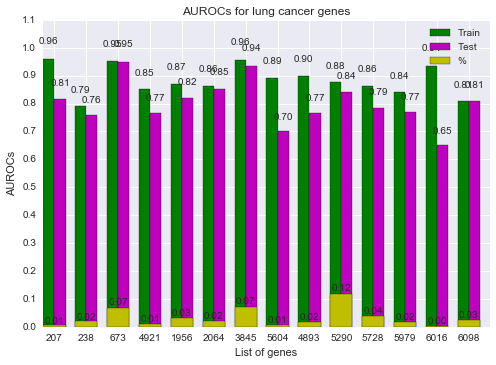

In [8]:
ind = np.arange(len(AUROCS_train))  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
train_results = ax.bar(ind, AUROCS_train, width, color='g')

test_results = ax.bar(ind + width, AUROCS_test, width, color='m')

per_results = ax.bar(ind, p, 2*width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('AUROCs')
ax.set_title('AUROCs for lung cancer genes')
ax.set_xlabel('List of genes')
ax.set_xticks(ind + width)
ax.set_xticklabels(list_of_tsgenes)
ax.set_yticks(np.arange(0, 1.11, 0.1))

ax.legend((train_results[0], test_results[0], per_results[0]), ('Train', 'Test','%'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % height,
                ha='center', va='bottom')

autolabel(train_results)
autolabel(test_results)
autolabel(per_results)

plt.show()
